<a href="https://www.kaggle.com/code/rahulchauhan016/artguard-ai-advanced-ai-vs-human-art-detection?scriptVersionId=294563519" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:

#  Imports & Mixed Precision

import os, math, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import clear_output
import cv2

mixed_precision.set_global_policy("mixed_float16")
print("TensorFlow:", tf.__version__)
print("Mixed precision enabled")


#  2 – Auto-detect Dataset Root (Multi-class)

BASE_PATH = "/kaggle/input/ai-art-vs-human-art"

def find_dataset_root(base_path):
    for root, dirs, files in os.walk(base_path):
        class_dirs = [d for d in dirs if not d.startswith('.')]
        if len(class_dirs) >= 2:
            return root, class_dirs
    return None, None

DATASET_PATH, CLASS_FOLDERS = find_dataset_root(BASE_PATH)
if DATASET_PATH is None:
    raise ValueError("Dataset root not found")

NUM_CLASSES = len(CLASS_FOLDERS)
CLASS_MODE = "binary" if NUM_CLASSES == 2 else "categorical"
LOSS_FUNCTION = "binary_crossentropy" if NUM_CLASSES == 2 else "categorical_crossentropy"

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

print("Dataset root:", DATASET_PATH)
print("Classes:", CLASS_FOLDERS)

#  3 – Data Generators (Strong Augmentation)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

train_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset="validation"
)

print("Class mapping:", train_gen.class_indices)


#  4 – Class Weights (Imbalance Handling)


class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


#  5 – Build EfficientNetV2S Model

from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)

if NUM_CLASSES == 2:
    output = Dense(1, activation="sigmoid", dtype="float32")(x)
else:
    output = Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) if NUM_CLASSES==2 else tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=loss_fn,
    metrics=["accuracy"]
)

model.summary()


#  6 – Callbacks


callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.3)
]

# 
#  7 – Train Model


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

# 8 – Fine Tuning

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=loss_fn,
    metrics=["accuracy"]
)

model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks, class_weight=class_weights)


# CELL 9 – Evaluation

val_gen.reset()
preds = model.predict(val_gen)

if NUM_CLASSES == 2:
    pred_labels = (preds > 0.5).astype(int).ravel()
else:
    pred_labels = np.argmax(preds, axis=1)

true_labels = val_gen.classes
print(classification_report(true_labels, pred_labels))
print(confusion_matrix(true_labels, pred_labels))


#  10 – Save Model

model.save("ai_vs_real_advanced_model.keras")
print("Model saved")


# 11 – Prediction (Top-3 + Image Display)

from tensorflow.keras.preprocessing import image

def predict_top3(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = image.img_to_array(img)/255.0
    arr = np.expand_dims(arr, 0)
    preds = model.predict(arr)[0]

    if NUM_CLASSES == 2:
        p = float(preds[0])
        probs = np.array([1-p, p])
    else:
        probs = preds

    class_names = list(train_gen.class_indices.keys())
    top3 = np.argsort(probs)[-3:][::-1]

    plt.imshow(img)
    plt.axis("off")
    plt.show()

    for i in top3:
        print(class_names[i], f"{probs[i]*100:.2f}%")


# 12 – Grad-CAM Utilities

last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    heatmap = conv_out[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap,0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


#  13 – Grad-CAM Single Image

def show_gradcam(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = image.img_to_array(img)
    inp = np.expand_dims(arr/255.0,0)

    preds = model.predict(inp)[0]
    if NUM_CLASSES==2:
        probs = np.array([1-float(preds[0]), float(preds[0])])
    else:
        probs = preds

    idx = np.argmax(probs)
    heatmap = make_gradcam_heatmap(inp, model, last_conv_layer_name, idx)

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(arr.astype(np.uint8), 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(arr.astype(np.uint8)); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap); plt.title("GradCAM"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
    plt.show()


# 14 – Slideshow to MP4 with Live Accuracy

def slideshow_to_video_with_accuracy(dataset_path, output_video="slideshow.mp4", fps=1, max_images=50):
    image_files = []
    for r, d, f in os.walk(dataset_path):
        for file in f:
            if file.lower().endswith((".jpg",".png",".jpeg")):
                image_files.append(os.path.join(r,file))
    image_files = image_files[:max_images]

    class_names = list(train_gen.class_indices.keys())

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video = cv2.VideoWriter(output_video, fourcc, fps, (IMG_SIZE, IMG_SIZE))

    correct = 0; total = 0

    for img_path in image_files:
        clear_output(wait=True)

        rel = os.path.relpath(img_path, DATASET_PATH)
        true_class = rel.split(os.sep)[0]

        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        arr = image.img_to_array(img)
        inp = np.expand_dims(arr/255.0,0)

        preds = model.predict(inp, verbose=0)[0]
        if NUM_CLASSES==2:
            probs = np.array([1-float(preds[0]), float(preds[0])])
        else:
            probs = preds

        idx = np.argmax(probs)
        pred_class = class_names[idx]
        conf = probs[idx]*100

        total+=1
        if pred_class==true_class: correct+=1
        acc = correct/total*100

        disp = arr.astype(np.uint8).copy()
        cv2.putText(disp, f"PRED: {pred_class} {conf:.1f}%", (10,25), cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,255,0),2)
        cv2.putText(disp, f"TRUE: {true_class}", (10,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,0),2)
        col=(0,255,0) if acc>=90 else (0,0,255)
        cv2.putText(disp, f"ACC: {acc:.2f}%", (10,75), cv2.FONT_HERSHEY_SIMPLEX,0.6,col,2)

        plt.imshow(disp); plt.axis("off"); plt.show()
        video.write(cv2.cvtColor(disp, cv2.COLOR_RGB2BGR))

    video.release()
    clear_output()
    print("Video saved:", output_video)
    print("Final accuracy:", acc)


# 15 – End

print("Advanced AI vs Real Art pipeline ready 🚀")


2026-01-28 14:06:37.563710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769609197.911605      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769609198.009345      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769609198.863457      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769609198.863503      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769609198.863506      24 computation_placer.cc:177] computation placer alr

TensorFlow: 2.19.0
Mixed precision enabled
Dataset root: /kaggle/input/ai-art-vs-human-art/Art
Classes: ['RealArt', 'AiArtData']
Found 777 images belonging to 2 classes.
Found 193 images belonging to 2 classes.
Class mapping: {'AiArtData': 0, 'RealArt': 1}
Class weights: {0: np.float64(0.9055944055944056), 1: np.float64(1.1163793103448276)}


I0000 00:00:1769609218.183083      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        648 │ rescaling[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 112, 112,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 21,123,937 (80.58 MB)

 Trainable params: 790,017 (3.01 MB)

 Non-trainable params: 20,333,920 (77.57 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20


I0000 00:00:1769609255.263660      80 service.cc:152] XLA service 0x783f30004930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769609255.263724      80 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769609260.552388      80 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1769609292.795224      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 214s 6s/step - accuracy: 0.5392 - loss: 0.9064 - val_accuracy: 0.5130 - val_loss: 0.6903 - learning_rate: 3.0000e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5426 - loss: 0.8214 - val_accuracy: 0.5337 - val_loss: 0.6908 - learning_rate: 3.0000e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5354 - loss: 0.8242 - val_accuracy: 0.5648 - val_loss: 0.6862 - learning_rate: 3.0000e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5577 - loss: 0.8238 - val_accuracy: 0.5492 - val_loss: 0.6857 - learning_rate: 3.0000e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5162 - loss: 0.8228 - val_accuracy: 0.5648 - val_loss: 0.6845 - learning_rate: 3.0000e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5571 - loss: 0.7810 - val_accuracy: 0.5544 - val_loss: 0.6848 - learning_rate: 3.0000e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5214 - loss: 0.7937 - 

#   Advanced Prediction (Top-3 + Grad-CAM + Bar Chart)

In [2]:


def advanced_predict_all(save_dir="gradcam_outputs"):
    import os, random, cv2, numpy as np
    import matplotlib.pyplot as plt
    from tensorflow.keras.preprocessing import image

    os.makedirs(save_dir, exist_ok=True)

    # -------------------------
    # 1. Pick random image
    # -------------------------
    images = []
    for root, dirs, files in os.walk(DATASET_PATH):
        for f in files:
            if f.lower().endswith((".jpg",".png",".jpeg")):
                images.append(os.path.join(root,f))

    img_path = random.choice(images)
    print("🎯 Selected image:", img_path)

    # -------------------------
    # 2. Load image
    # -------------------------
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_arr = image.img_to_array(img)
    inp = np.expand_dims(img_arr/255.0, 0)

    # -------------------------
    # 3. Predict
    # -------------------------
    preds = model.predict(inp, verbose=0)[0]
    class_names = list(train_gen.class_indices.keys())

    if preds.shape[-1] == 1:
        p = float(preds[0])
        probs = np.array([1-p, p])
    else:
        probs = preds

    top3_idx = np.argsort(probs)[-3:][::-1]
    top3_classes = [class_names[i] for i in top3_idx]
    top3_probs = [probs[i]*100 for i in top3_idx]

    print("\n🏆 Top-3 Predictions:")
    for c,p in zip(top3_classes, top3_probs):
        print(f"{c} → {p:.2f}%")

    # -------------------------
    # 4. SAFE Grad-CAM
    # -------------------------
    def safe_gradcam(img_array):
        try:
            grad_model = tf.keras.models.Model(
                [model.inputs],
                [model.get_layer(last_conv_layer_name).output, model.output]
            )

            with tf.GradientTape() as tape:
                conv_out, predictions = grad_model(img_array)

                if predictions.shape[-1] == 1:
                    loss = predictions[:,0]
                else:
                    loss = predictions[:, top3_idx[0]]

            grads = tape.gradient(loss, conv_out)
            pooled = tf.reduce_mean(grads, axis=(0,1,2))

            conv_out = conv_out[0]
            heatmap = conv_out @ pooled[...,tf.newaxis]
            heatmap = tf.squeeze(heatmap)

            heatmap = tf.maximum(heatmap,0)

            max_val = tf.reduce_max(heatmap)
            if float(max_val) == 0.0:
                return None

            heatmap = heatmap / max_val
            heatmap = heatmap.numpy().astype("float32")

            if heatmap.ndim != 2:
                return None

            return heatmap

        except Exception as e:
            print("⚠️ Grad-CAM failed:", e)
            return None

    heatmap = safe_gradcam(inp)

    # -------------------------
    # 5. Build overlay safely
    # -------------------------
    original = img_arr.astype(np.uint8)

    if heatmap is not None:
        try:
            heatmap = np.ascontiguousarray(heatmap, dtype=np.float32)
            heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
            heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap_resized), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)
        except Exception as e:
            print("⚠️ OpenCV overlay failed:", e)
            overlay = original.copy()
    else:
        print("⚠️ No valid heatmap – showing original image")
        overlay = original.copy()

    # -------------------------
    # 6. Save result
    # -------------------------
    save_path = os.path.join(save_dir, os.path.basename(img_path))
    cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    # -------------------------
    # 7. Visualization
    # -------------------------
    plt.figure(figsize=(14,5))

    plt.subplot(1,3,1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM → {top3_classes[0]}")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.barh(top3_classes[::-1], top3_probs[::-1])
    plt.xlabel("Confidence (%)")
    plt.title("Top-3 Confidence")

    plt.tight_layout()
    plt.show()

    print("\n💾 Saved to:", save_path)
    print("✅ Advanced pipeline completed successfully")


🎯 Selected image: /kaggle/input/ai-art-vs-human-art/Art/RealArt/Women-clothing-Kenya-East-Africa.jpg

🏆 Top-3 Predictions:
RealArt → 54.67%
AiArtData → 45.33%


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


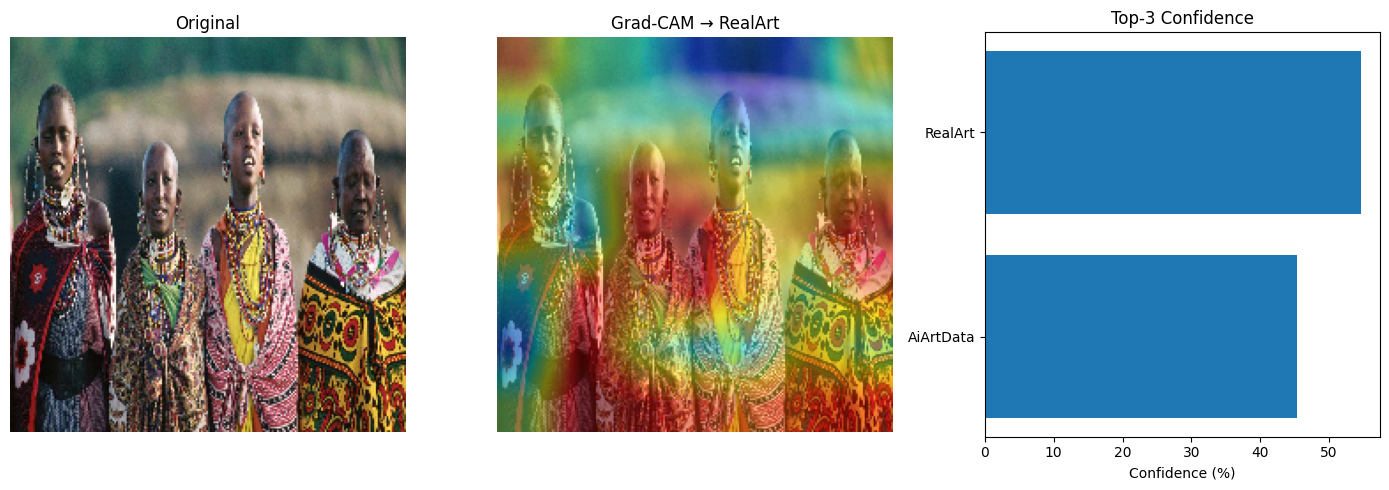


💾 Saved to: gradcam_outputs/Women-clothing-Kenya-East-Africa.jpg
✅ Advanced pipeline completed successfully


In [3]:
advanced_predict_all()


#  MP4 Slideshow with Grad-CAM Overlay 


In [4]:

def gradcam_slideshow_to_mp4(
    output_video="artguard_ai_gradcam_slideshow.mp4",
    fps=1,
    max_images=40
):
    import os, cv2, numpy as np
    from tensorflow.keras.preprocessing import image
    import matplotlib.pyplot as plt

    print("🎬 Creating Grad-CAM slideshow video...")

    # -------------------------
    # Collect images
    # -------------------------
    image_files = []
    for root, dirs, files in os.walk(DATASET_PATH):
        for f in files:
            if f.lower().endswith((".jpg",".png",".jpeg")):
                image_files.append(os.path.join(root,f))

    if len(image_files) == 0:
        raise ValueError("No images found!")

    image_files = image_files[:max_images]

    class_names = list(train_gen.class_indices.keys())

    # -------------------------
    # Video writer
    # -------------------------
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video = cv2.VideoWriter(output_video, fourcc, fps, (IMG_SIZE, IMG_SIZE))

    # -------------------------
    # Safe Grad-CAM function
    # -------------------------
    def safe_gradcam(img_array, class_index):
        try:
            grad_model = tf.keras.models.Model(
                [model.inputs],
                [model.get_layer(last_conv_layer_name).output, model.output]
            )

            with tf.GradientTape() as tape:
                conv_out, preds = grad_model(img_array)

                if preds.shape[-1] == 1:
                    loss = preds[:, 0]
                else:
                    loss = preds[:, class_index]

            grads = tape.gradient(loss, conv_out)
            pooled = tf.reduce_mean(grads, axis=(0,1,2))

            conv_out = conv_out[0]
            heatmap = conv_out @ pooled[..., tf.newaxis]
            heatmap = tf.squeeze(heatmap)

            heatmap = tf.maximum(heatmap, 0)
            max_val = tf.reduce_max(heatmap)

            if float(max_val) == 0.0:
                return None

            heatmap = (heatmap / max_val).numpy().astype("float32")

            if heatmap.ndim != 2:
                return None

            return heatmap

        except:
            return None

    # -------------------------
    # Process images
    # -------------------------
    for i, img_path in enumerate(image_files, 1):
        print(f"Processing {i}/{len(image_files)}")

        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_arr = image.img_to_array(img)
        inp = np.expand_dims(img_arr/255.0, 0)

        preds = model.predict(inp, verbose=0)[0]

        if preds.shape[-1] == 1:
            p = float(preds[0])
            probs = np.array([1-p, p])
        else:
            probs = preds

        class_idx = int(np.argmax(probs))
        pred_class = class_names[class_idx]
        confidence = probs[class_idx]*100

        # Grad-CAM
        heatmap = safe_gradcam(inp, class_idx)

        original = img_arr.astype(np.uint8)

        if heatmap is not None:
            heatmap = np.ascontiguousarray(heatmap, dtype=np.float32)
            heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
            heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap_resized), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)
        else:
            overlay = original.copy()

        # Add text
        cv2.putText(overlay, f"{pred_class} ({confidence:.1f}%)",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

        # Write frame
        video.write(cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    video.release()

    print("✅ Slideshow video created!")
    print("📁 Saved as:", output_video)
    print("⬇️ Download from Kaggle Output panel")

    return output_video


In [5]:
gradcam_slideshow_to_mp4()


🎬 Creating Grad-CAM slideshow video...
Processing 1/40
Processing 2/40
Processing 3/40
Processing 4/40
Processing 5/40
Processing 6/40
Processing 7/40
Processing 8/40
Processing 9/40
Processing 10/40
Processing 11/40
Processing 12/40
Processing 13/40
Processing 14/40
Processing 15/40
Processing 16/40
Processing 17/40
Processing 18/40
Processing 19/40
Processing 20/40
Processing 21/40
Processing 22/40
Processing 23/40
Processing 24/40
Processing 25/40
Processing 26/40
Processing 27/40
Processing 28/40
Processing 29/40
Processing 30/40
Processing 31/40
Processing 32/40
Processing 33/40
Processing 34/40
Processing 35/40
Processing 36/40
Processing 37/40
Processing 38/40
Processing 39/40
Processing 40/40
✅ Slideshow video created!
📁 Saved as: artguard_ai_gradcam_slideshow.mp4
⬇️ Download from Kaggle Output panel


'artguard_ai_gradcam_slideshow.mp4'